# InceptionV3-fine-tune

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os
import time
import zipfile
import pickle
from PIL import Image
from shutil import copy2

### Run name

In [2]:
project_name = 'dog-breed-identification'
step_name = 'InceptionV3-fine-tune'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d-%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: dog-breed-identification_InceptionV3-fine-tune_20180116-112653


### Basic folders

In [3]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)



input_path: D:\ref\Kaggle\dog-breed-identification\input
log_path: D:\ref\Kaggle\dog-breed-identification\log
model_path: D:\ref\Kaggle\dog-breed-identification\model
output_path: D:\ref\Kaggle\dog-breed-identification\output


### Build model

In [4]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Input
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

from keras.applications.vgg19 import VGG19, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

Using TensorFlow backend.


In [5]:
def build_model():
    base_model = InceptionV3(weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(120, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in model.layers:
       layer.trainable = True
#     for layer in model.layers[:249]:
#        layer.trainable = False
#     for layer in model.layers[249:]:
#        layer.trainable = True
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [6]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [8]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** x)

# def get_lr(x):
#     lr = round(1e-4 * 0.995 ** x, 6)
#     if lr < 5e-5:
#         lr = 5e-5
#     print(lr, end='  ')
#     return lr
# annealer = LearningRateScheduler(get_lr)

# log_dir = os.path.join(log_path, run_name)
# print('log_dir:' + log_dir)
# tensorBoard = TensorBoard(log_dir=log_dir)

callbacks = [annealer]

In [9]:
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True
)
train_generator = train_datagen.flow_from_directory(
    './input/data_train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode = "categorical",
    seed=2018
)
print(train_generator.classes)

val_datagen = ImageDataGenerator(
    rescale=1./255
)
val_generator = val_datagen.flow_from_directory(
    './input/data_val',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode = "categorical",
    seed=2018
)
print(val_generator.classes)

Found 9199 images belonging to 120 classes.
[  0   0   0 ..., 119 119 119]
Found 1023 images belonging to 120 classes.
[  0   0   0 ..., 119 119 119]


In [10]:
%%time
print(len(train_generator.classes))
print(len(val_generator.classes))
steps_per_epoch = len(train_generator.classes) / batch_size
validation_steps = len(val_generator.classes) / batch_size
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50, #Increase this when not on Kaggle kernel
    verbose=1,  #1 for ETA, 0 for silent
    callbacks=callbacks,
    max_queue_size=256,
    workers=32,
    validation_steps=validation_steps,
    validation_data=val_generator
)

9199
1023
Epoch 1/50
144/143 [==============================] - 117s 810ms/step - loss: 4.5238 - acc: 0.0325 - val_loss: 5.7993 - val_acc: 0.0293
Epoch 2/50
144/143 [==============================] - 99s 691ms/step - loss: 3.9346 - acc: 0.0713 - val_loss: 5.3506 - val_acc: 0.0626
Epoch 3/50
144/143 [==============================] - 101s 704ms/step - loss: 3.6090 - acc: 0.1017 - val_loss: 4.0657 - val_acc: 0.0987
Epoch 4/50
144/143 [==============================] - 99s 689ms/step - loss: 3.3749 - acc: 0.1348 - val_loss: 4.0818 - val_acc: 0.0899
Epoch 5/50
144/143 [==============================] - 101s 700ms/step - loss: 3.2241 - acc: 0.1633 - val_loss: 3.9372 - val_acc: 0.1056
Epoch 6/50
144/143 [==============================] - 100s 696ms/step - loss: 3.0554 - acc: 0.1918 - val_loss: 3.6236 - val_acc: 0.1496
Epoch 7/50
144/143 [==============================] - 100s 697ms/step - loss: 2.9057 - acc: 0.2209 - val_loss: 3.8600 - val_acc: 0.1378
Epoch 8/50
144/143 [====================

In [11]:
# final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
final_loss, final_acc = model.evaluate_generator(val_generator, steps=validation_steps)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 2.3699, final accuracy: 0.5103


In [12]:
final_acc_str = '{0:0>4}'.format(int(final_acc*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

dog-breed-identification_InceptionV3-fine-tune_20180116-112653_5102


In [13]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


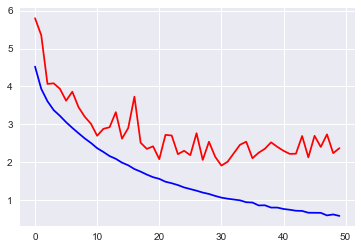

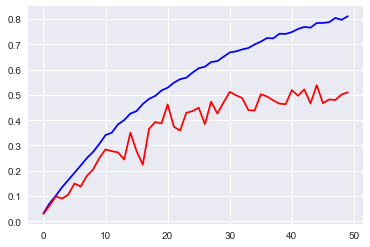

In [14]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [15]:
saveModel(model, run_name_acc)

### Predict

In [16]:
print(run_name_acc)

dog-breed-identification_InceptionV3-fine-tune_20180116-112653_5102
